In [1]:
#07 Plotting
## This code does the plotting 

In [2]:
# import libraries
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Patch, Rectangle
from matplotlib.lines import Line2D
import pandas as pd
weatherclimateED = pd.read_csv("weatherclimateED.csv", parse_dates = [0], dayfirst = True)
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import itertools
import statsmodels.api as sm
from pycirclize import Circos
import os

In [3]:
from epiweeks import Week, Year
from datetime import date
def create_epiweek(date):
    return Week.fromdate(date)
def create_epiweekplot(epiweek):
    epiweek = str(epiweek)
    return F'Y{epiweek[:4]}W{epiweek[4:]}'
def create_epiweek_fromstr(str):
    return Week.fromstring(str)

In [4]:
def find_min_model(lag, step, target_var, error_metric_directory, error_metric):
    error_file_path = os.path.join(target_var, error_metric_directory, F'L{lag}_S{step}.csv')
    if os.path.isfile(error_file_path):
        error_df = pd.read_csv(error_file_path)
        min_val = error_df[error_metric].min()*100
        min_model = error_df.iloc[error_df[error_metric].idxmin(), 0]
    else:
        min_val = 0
        min_model = 'N/A'
    return min_val, min_model

In [5]:
def color_picker(min_model_name):
    naive_type = ['naive']
    simple_type = ['linreg', 'ridge', 'lasso', 'elasticnet', 'randomforest', 'gradientboost', 'knn']
    if min_model_name in naive_type:
        return 'white'
    if min_model_name in simple_type:
        return 'lightgrey'
    else:
        return 'black'

In [6]:
def disease_circos_df(lag, step, disease_list, error_metric_directory, error_metric):
    circos_df = pd.DataFrame()
    for target_var in disease_list:
        min_val, min_model = find_min_model(lag, step, target_var, error_metric_directory, error_metric)
        circos_df.at[target_var, 'min_val'], circos_df.at[target_var, 'min_model'] = min_val, min_model
    
    circos_df['color'] = circos_df['min_model'].map(color_picker)
    
    circos_df.rename(index={'Factors influencing health status and contact with health services':'Health status factors'},inplace=True)
    circos_df.rename(index={'Cardiovascular disease':'Cardiovascular'},inplace=True)
    circos_df.rename(index={'Chronic respiratory disease':'Chronic respiratory'},inplace=True)
    circos_df.rename(index={'Digestive disease':'Digestive'},inplace=True)
    circos_df.rename(index={'Endocrine disorders':'Endocrine'},inplace=True)
    circos_df.rename(index={'Genitourinary disorders':'Genitourinary'},inplace=True)
    circos_df.rename(index={'Infectious and Parasitic Diseases':'Infectious & Parasitic'},inplace=True)
    circos_df.rename(index={'Musculoskeletal disease':'Musculoskeletal'},inplace=True)
    circos_df.rename(index={'Neurological and sense disorders':'Neurological & Sense'},inplace=True)
    circos_df.rename(index={'Oral diseases':'Oral'},inplace=True)
    circos_df.rename(index={'Respiratory Infection':'Respiratory'},inplace=True)
    circos_df.rename(index={'Skin diseases':'Skin'},inplace=True)
    circos_df.rename(index={'Ill-defined injuries/accidents':'Other Injuries'},inplace=True)
    circos_df.rename(index={'Ill-defined diseases':'Other Diseases'},inplace=True)
    
    #print(circos_df.index.values)
    return circos_df

In [7]:
def generate_circos_df(lag, maxstep, disease_list_file, error_metric_directory, error_metric):
    disease_list = []
    with open(disease_list_file, 'r') as file:
        for line in file:
            # Remove linebreak which is the last character of the string
            disease = line[:-1]
            # Add item to the list
            disease_list.append(disease)
    '''
    ## Removed because error value too high (SMAPE > 35%)
    disease_list.remove('Nutritional deficiencies')
    disease_list.remove('Congenital Abnormalities')
    disease_list.remove('Perinatal conditions')

    # Removed because error value not ideal (MAPE > 20%)
    disease_list.remove('Maternal conditions')
    disease_list.remove('Other neoplasms')
    disease_list.remove('Mental disorders')

    # Removed before timescale is to 2016, not 2018
    disease_list.remove('Intentional injuries')
    disease_list.remove('Unintentional injuries')
    '''
    circos_df_dict = {}
    
    for step in range(1, maxstep+1):
        circos_df_dict[step] = disease_circos_df(lag, step, disease_list, error_metric_directory, error_metric)
    
    #print(disease_list)
    return circos_df_dict


In [206]:
circos_df = generate_circos_df(8, 12, 'selected_variables.txt', 'error_metrics_full', 'MAPE')
circos_df

{1:                           min_val       min_model      color
 Cardiovascular           5.732920           lasso  lightgrey
 Chronic respiratory      6.363226           lasso  lightgrey
 Health status factors    8.328202      elasticnet  lightgrey
 Digestive                5.201641    randomforest  lightgrey
 Endocrine                7.774499         lasso_2      black
 Malignant neoplasms     10.416092  randomforest_2      black
 Diabetes mellitus       11.610643         ridge_2      black
 Genitourinary            6.019455             knn  lightgrey
 Musculoskeletal          5.157962         lasso_2      black
 Infectious & Parasitic   6.580034    randomforest  lightgrey
 Other Diseases           4.956559           lasso  lightgrey
 Neurological & Sense     5.616570           lasso  lightgrey
 Oral Diseases            9.748996      elasticnet  lightgrey
 Other neoplasms         20.318002           lasso  lightgrey
 Respiratory              7.399023       mean_xmse      black
 Skin

In [223]:
for key in circos_df:
    df = circos_df[key]
    x = len(df[df['min_model']=='randomforest_2'])
    y = len(df[df['min_model']=='elasticnet_2'])
    z = len(df[df['color']=='black'])
    print(x+y, z)

1 5
2 7
2 8
0 7
7 10
3 9
3 9
3 10
2 10
1 11
3 10
5 10


In [213]:
print(round(100-(5+7+8)/(16*3)*100,3))
print(round(100-(11+10+10)/(16*3)*100,3))
print(round((11+10+10)/(16*3)*100,3))

58.333
35.417
64.583


In [222]:
model_count = {}
for step in range(1,13):
    model_count[step] = circos_df[step]['min_model'].value_counts(ascending=False)
model_count[1]

count_model = pd.DataFrame()
for step in range(1,13):
    count_model = pd.concat([count_model, model_count[step]],axis=1)
count_model.columns = range(1,13)
count_model['sum'] = count_model.sum(axis=1)
count_model.sort_values('sum', ascending=False)

,1,2,3,4,5,6,7,8,9,10,11,12,sum
randomforest,2.0,4.0,3.0,2.0,2.0,4.0,3.0,3.0,3.0,2.0,3.0,1.0,32.0
lasso,6.0,3.0,4.0,1.0,2.0,1.0,3.0,2.0,2.0,1.0,2.0,1.0,28.0
knn_2,NaN,NaN,2.0,1.0,1.0,2.0,1.0,3.0,2.0,3.0,2.0,2.0,19.0
lasso_2,2.0,1.0,NaN,2.0,NaN,2.0,2.0,2.0,1.0,4.0,2.0,NaN,18.0
randomforest_2,1.0,1.0,2.0,NaN,3.0,1.0,1.0,1.0,1.0,1.0,2.0,3.0,17.0
elasticnet,2.0,1.0,1.0,3.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,17.0
elasticnet_2,NaN,1.0,NaN,NaN,4.0,2.0,2.0,2.0,1.0,NaN,1.0,2.0,15.0
linreg_2,NaN,1.0,1.0,1.0,NaN,1.0,2.0,NaN,2.0,1.0,NaN,1.0,10.0
mean_rmse,NaN,NaN,1.0,1.0,1.0,NaN,NaN,NaN,NaN,1.0,2.0,2.0,8.0
ridge_2,1.0,2.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0


In [193]:
min_error_df = pd.DataFrame()
for step in range(1,13):
    df = circos_df[step]
    for disease in df.index.values:
        min_error_df.at[disease, step] = df.loc[disease, 'min_val']
min_error_df['max'] = min_error_df.max(axis=1)
min_error_df.sort_values(by='max')

,1,2,3,4,5,6,7,8,9,10,11,12,max
Digestive,5.201641,5.515796,5.504517,5.470861,5.746790,5.767789,5.869444,5.969791,6.174014,6.096400,6.131868,6.082725,6.174014
Genitourinary,6.019455,6.151018,6.165648,6.090635,6.242604,6.027517,5.893957,5.666002,5.845566,5.752805,5.939190,5.779881,6.242604
Cardiovascular,5.732920,6.405242,6.288481,6.741298,6.287957,6.579244,6.609362,6.397490,6.249457,6.126317,6.041926,5.681301,6.741298
Musculoskeletal,5.157962,5.921212,5.914773,6.328406,6.584979,6.770159,7.051829,6.997662,6.805147,6.917706,6.785659,6.868198,7.051829
Chronic respiratory,6.363226,6.618476,6.963000,6.944525,6.948124,7.073143,6.889347,6.921473,7.084434,6.881593,6.826926,6.629466,7.084434
Neurological & Sense,5.616570,6.186946,6.217468,6.245100,7.101378,6.898804,6.719390,6.729503,6.241034,6.828521,6.900282,6.912535,7.101378
Other Diseases,4.956559,5.605410,5.930907,5.648268,6.809044,6.566035,6.532953,6.887906,7.120525,7.108194,7.601192,7.798211,7.798211
Endocrine,7.774499,8.015772,7.755087,7.784269,7.974824,7.801140,7.759578,7.175079,7.320066,7.168562,7.164446,7.306205,8.015772
Skin,6.687409,7.380214,7.333050,7.423435,7.731106,7.809722,8.040242,8.044300,8.217307,8.167517,8.262071,8.164639,8.262071
Infectious & Parasitic,6.580034,6.945322,7.295548,7.160816,7.509472,7.081327,7.625391,8.129357,8.059674,8.203355,8.464094,8.393522,8.464094


In [194]:
def find_min_max(circos_df, step_list):
    min_max = pd.DataFrame()
    for step in step_list:
        min_max.at[F'step{step}', 'min'] = circos_df[step]['min_val'].min()
        min_max.at[F'step{step}', 'max'] = circos_df[step]['min_val'].max()
    return min_max

In [215]:
min_max = find_min_max(circos_df, [1,2,3,4,5,6,7,8,9,10,11,12])
min_max['max'].max()

20.32017825890145

In [196]:
def generate_circos_plot(circos_df_dict, step, ax):
    ax.set_title(F'Step {step}', y=title_y, pad=title_padding, fontsize=fontsize)
    circos_df = circos_df_dict[step]
    sectors = {"A": len(circos_df)}
    circos = Circos(sectors, space=0)
    sector = circos.sectors[0]
    x = range(0,len(circos_df))
    y = circos_df['min_val']

    track1 = sector.add_track((0, 100), r_pad_ratio=0)
    pos_list = list(range(0, int(track1.size) + 0))
    labels = list(map(str, range(1,len(circos_df)+1)))

    track1.xticks(
        pos_list,
        labels,
        outer=True,
        tick_length=2,
        label_margin=4,
        label_orientation="horizontal",
    )

    track1_colors = circos_df['color']
    track1.bar(x, y, bottom=0, width=1, vmax=all_vmax, align='center', color=track1_colors, ec='black', lw=0.3)
    track1.grid()
    track2 = sector.add_track((100,100))
    track2.axis(ec='lightgrey')
    fig = circos.plotfig(ax=ax)

    if step == 11:
        disease_handles = []
        for i in range(0, len(circos_df)):
            disease_handles.append(Line2D([0], [0], color='b', lw=0, label=str(i+1)+": "+circos_df.index.values[i]))
        
        _ = circos.ax.legend(
            handles = disease_handles,
            bbox_to_anchor=(-2, -0.7),
            loc="center left",
            fontsize=12,
            ncol=3,
            columnspacing = 0,
        )
    if step == 12:
        

        rect_handles = [Patch(color='white', ec='black', lw=0.5, label='Naive'),
                        Patch(color='lightgrey', ec='black', lw=0.5, label='Simple'),
                        Patch(color='black', label='Combination')]
        
        _ = circos.ax.legend(
            handles=rect_handles,
            bbox_to_anchor=(-4.8, -0.47),
            loc="center left",
            fontsize=12,
            #title="Legend",
            ncol=1,
        )

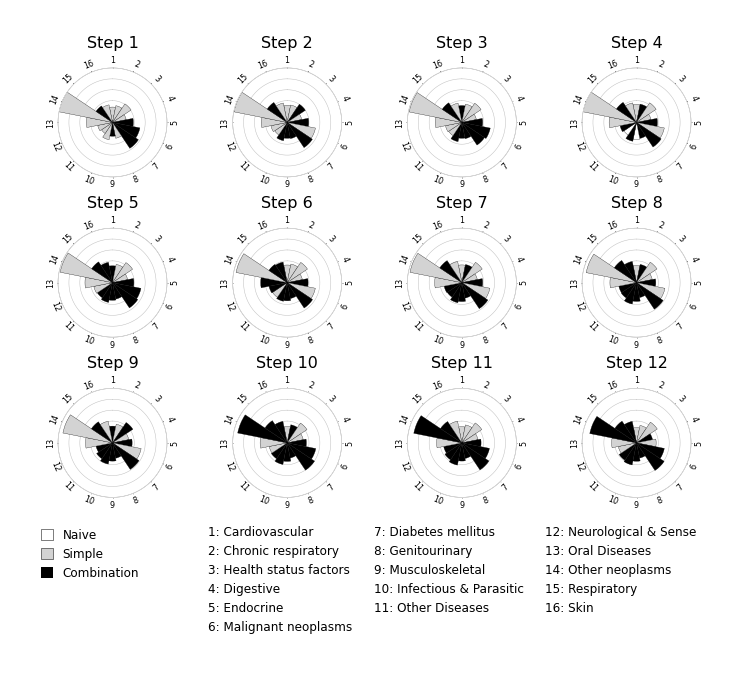

In [197]:
fig, ((polar_ax1, polar_ax2, polar_ax3, polar_ax4), 
      (polar_ax5, polar_ax6, polar_ax7, polar_ax8),
      (polar_ax9, polar_ax10, polar_ax11, polar_ax12)) = plt.subplots(nrows=3, 
                                                                 ncols=4, 
                                                                 subplot_kw={'projection': 'polar'}, 
                                                                 figsize=(12,8)
                                                                )
title_padding=6
title_y=1.1
fontsize=16
all_vmax = min_max['max'].max()

'''
Step 1, 3, 6, 8 plots
'''
generate_circos_plot(circos_df, 1, polar_ax1)
generate_circos_plot(circos_df, 2, polar_ax2)
generate_circos_plot(circos_df, 3, polar_ax3)
generate_circos_plot(circos_df, 4, polar_ax4)
generate_circos_plot(circos_df, 5, polar_ax5)
generate_circos_plot(circos_df, 6, polar_ax6)
generate_circos_plot(circos_df, 7, polar_ax7)
generate_circos_plot(circos_df, 8, polar_ax8)
generate_circos_plot(circos_df, 9, polar_ax9)
generate_circos_plot(circos_df, 10, polar_ax10)
generate_circos_plot(circos_df, 11, polar_ax11)
generate_circos_plot(circos_df, 12, polar_ax12)
plt.subplots_adjust(hspace=0.4)
plt.savefig('Fig5B_circosplot_full.pdf') 

['Cardiovascular disease', 'Chronic respiratory disease', 'Factors influencing health status and contact with health services', 'Digestive disease', 'Endocrine disorders', 'Malignant neoplasms', 'Diabetes mellitus', 'Genitourinary disorders', 'Musculoskeletal disease', 'Infectious and Parasitic Diseases', 'Ill-defined diseases', 'Neurological and sense disorders', 'Oral Diseases', 'Other neoplasms', 'Respiratory Infection', 'Skin diseases']


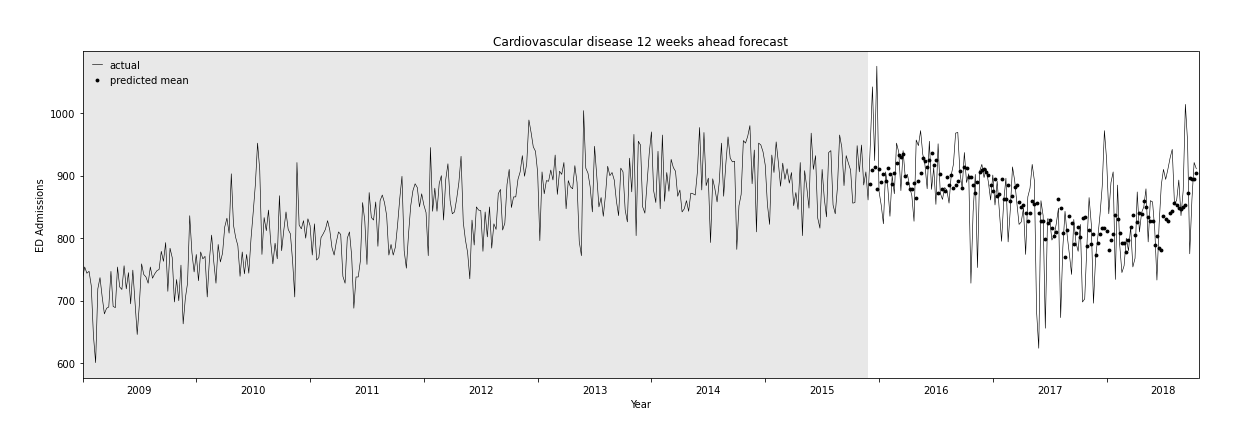

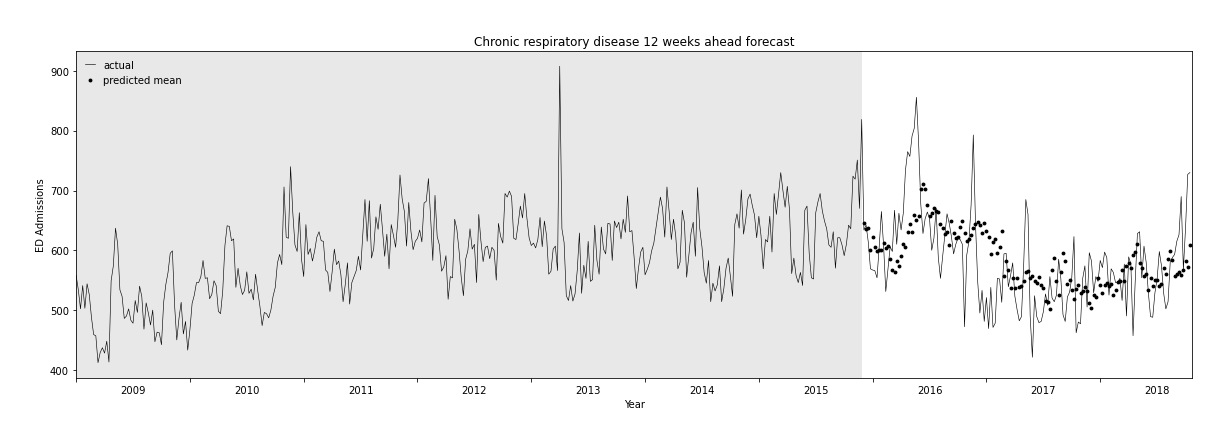

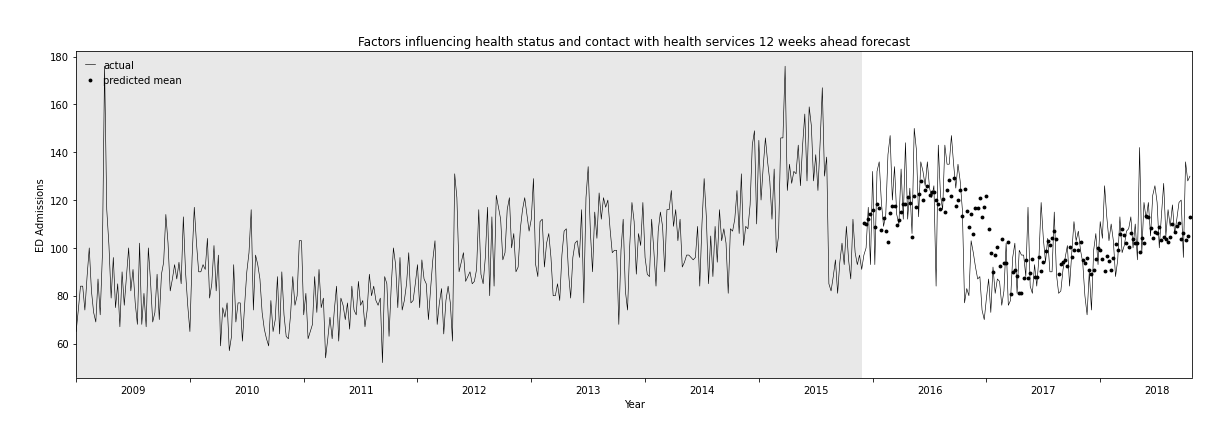

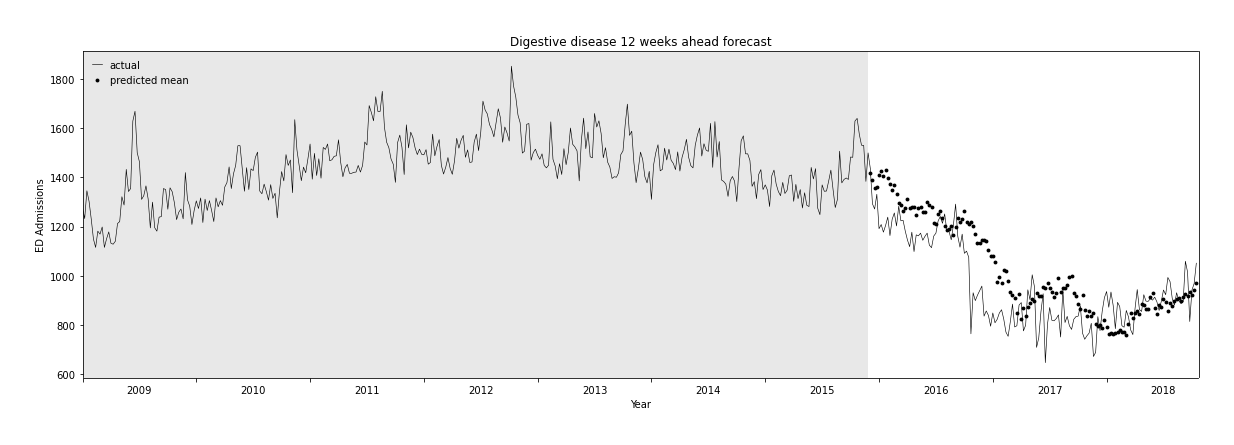

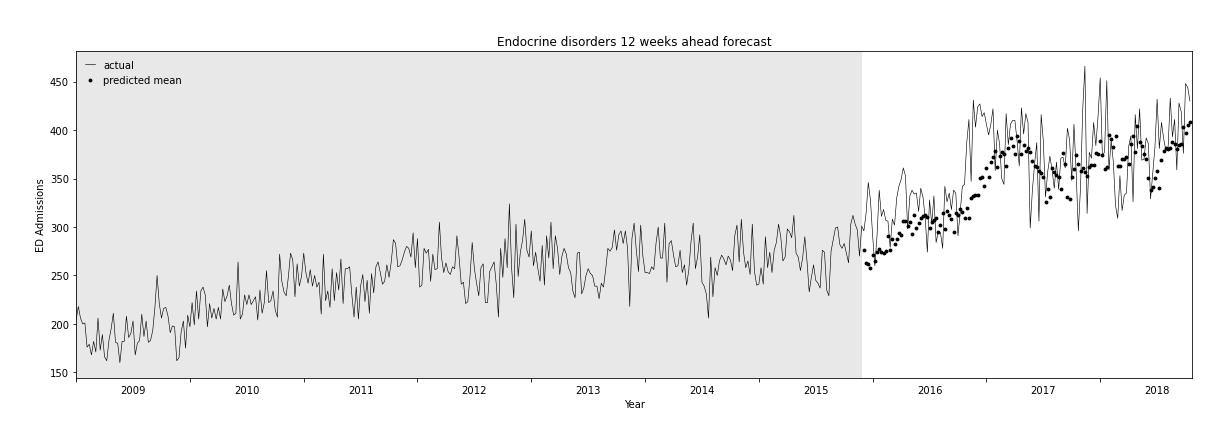

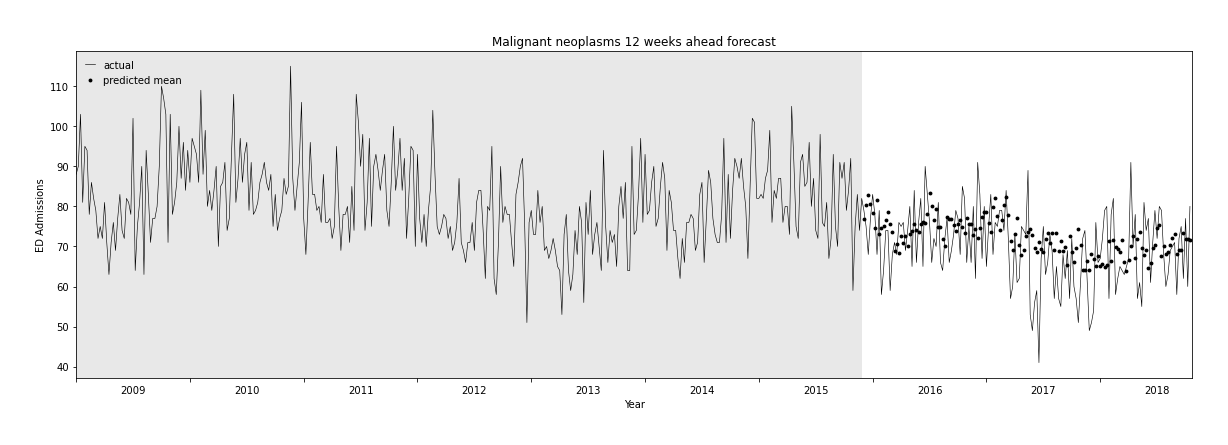

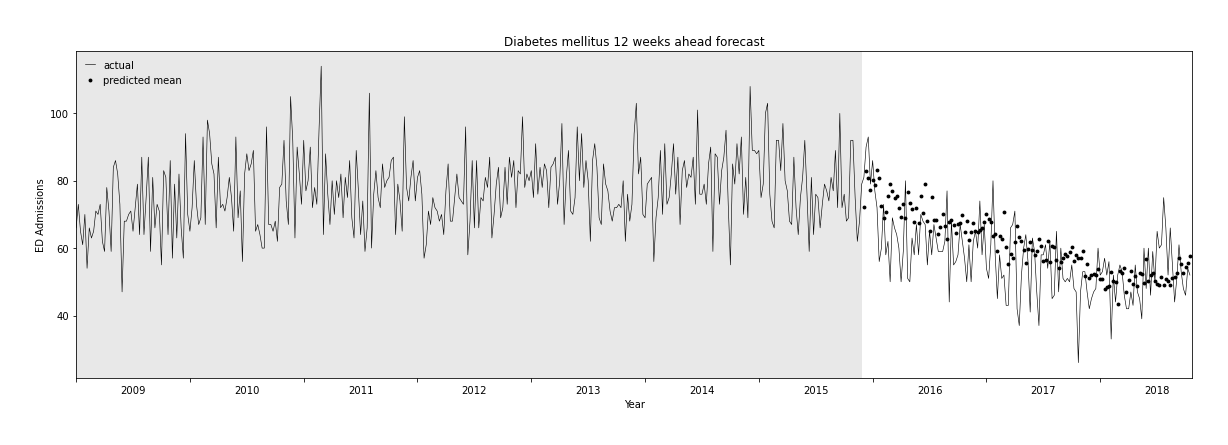

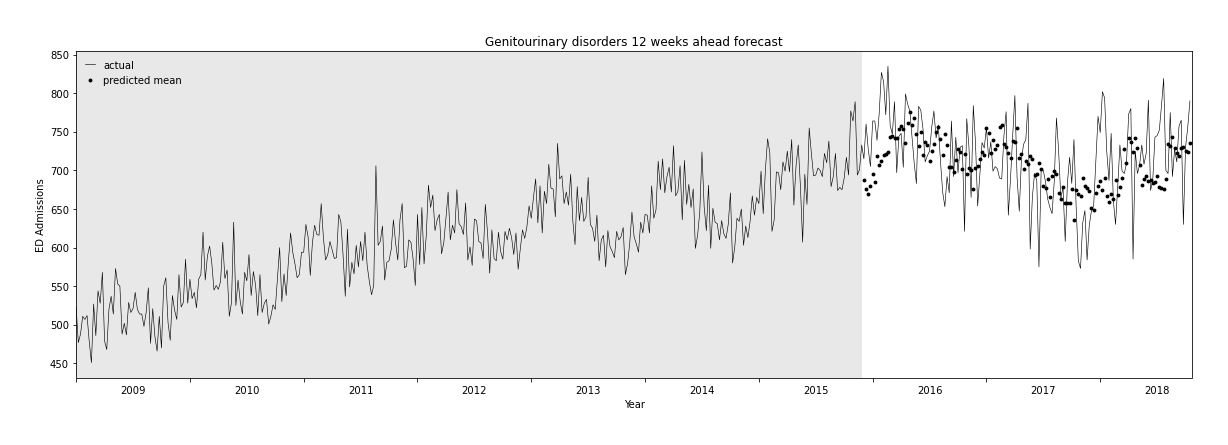

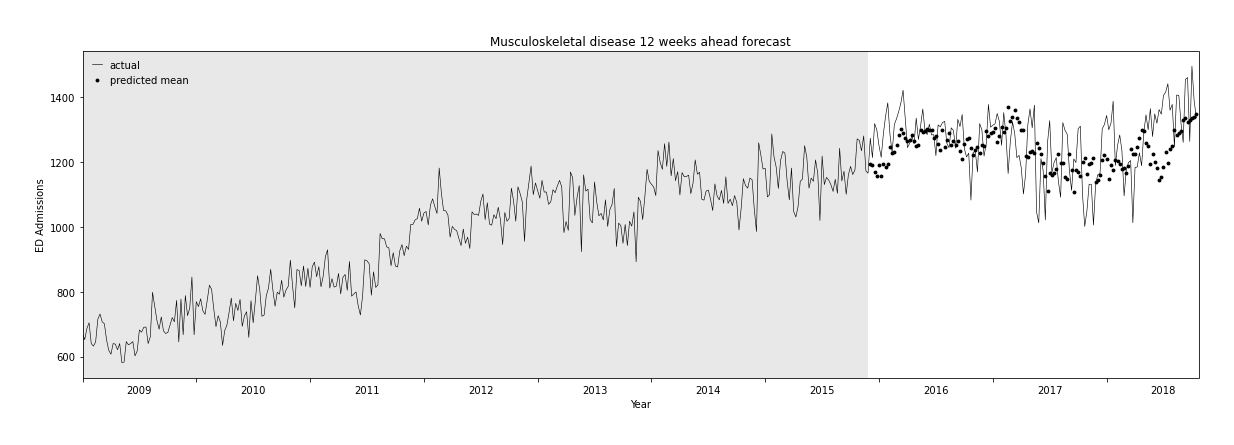

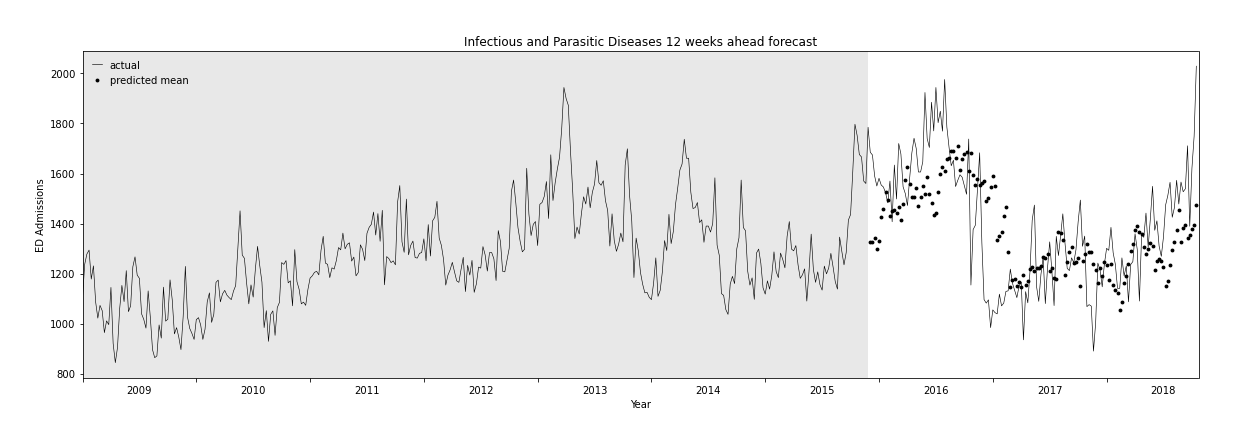

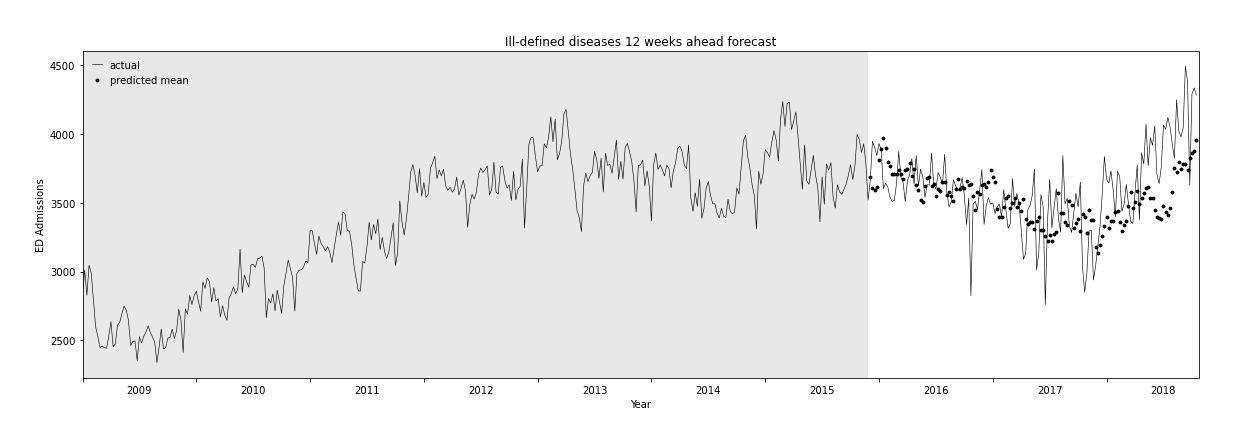

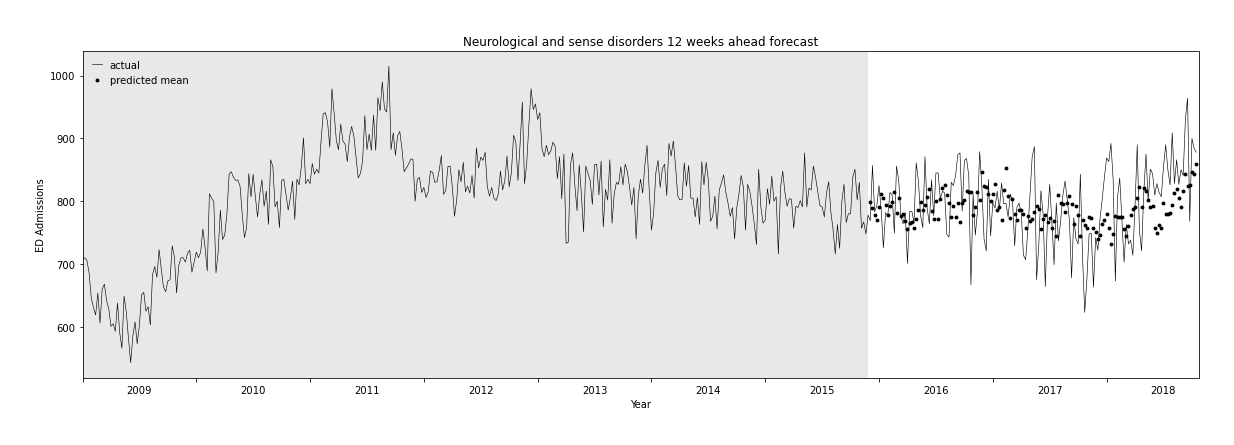

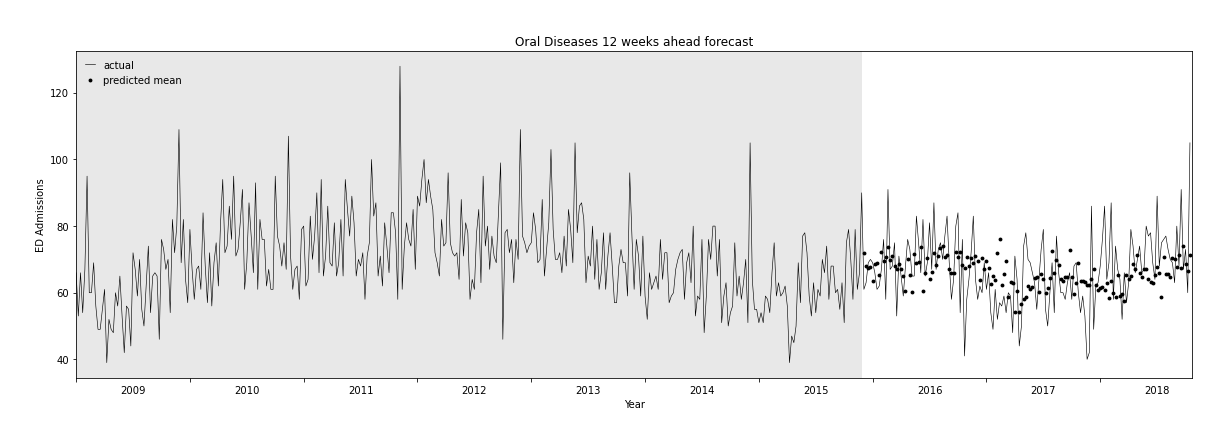

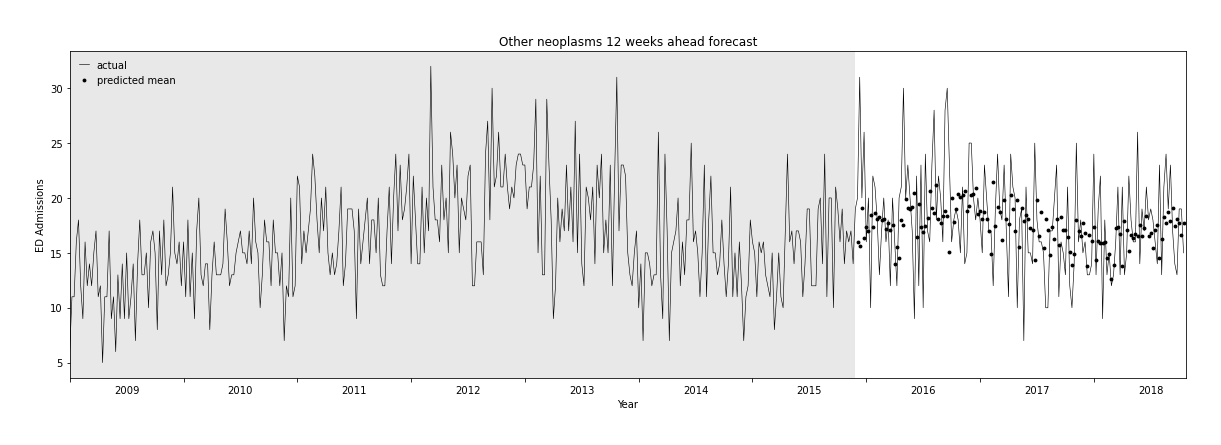

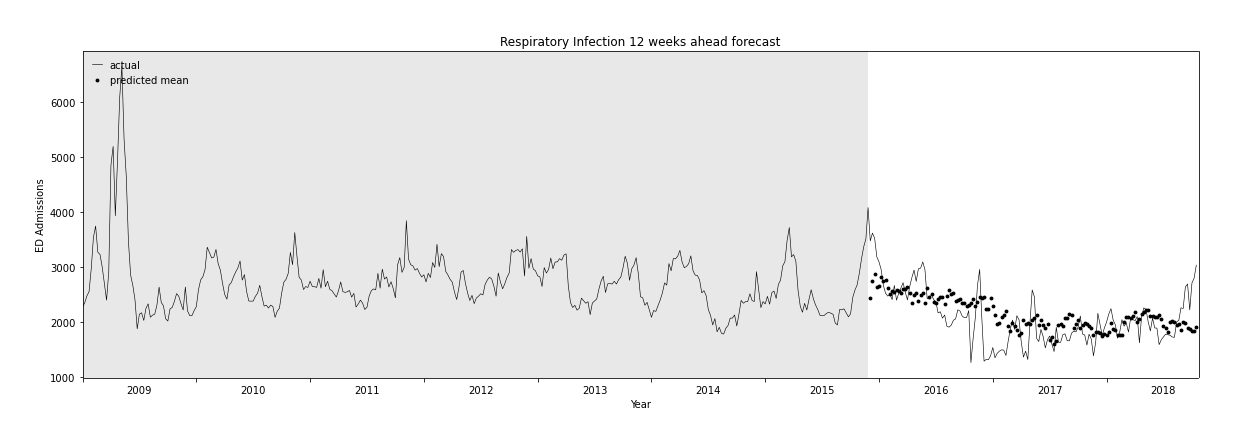

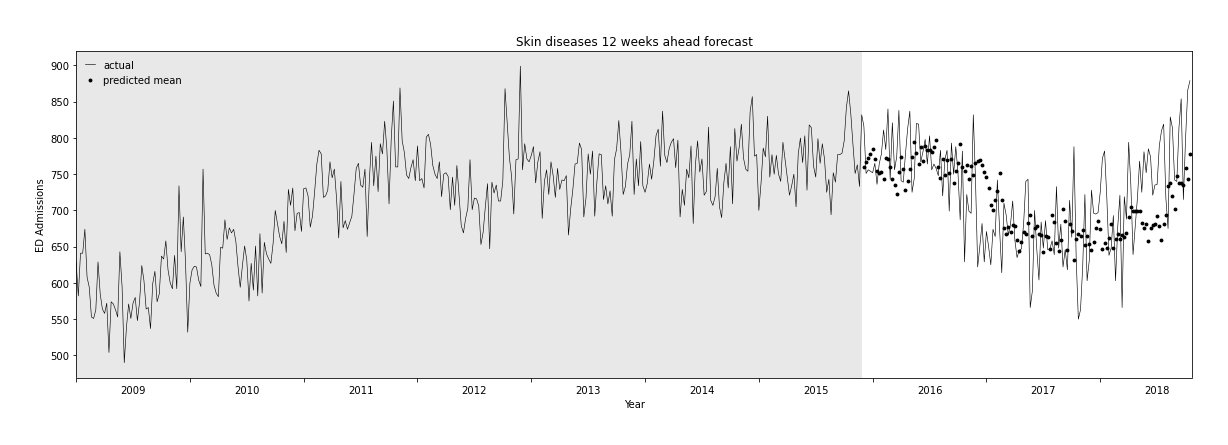

In [199]:
def single_plot(dataset, lag, step, target_var, model):
    y_pred_all = dataset.copy()
    
    fig, ax1 = plt.subplots(1,1, figsize=(20,6))
    # Set the x-axis limits
    plt.xlim([0,len(dataset)])

    # Shade the training dataset
    epiweek_values = list(y_pred_all.index.values)
    first_valid_index = epiweek_values.index(y_pred_all[model].first_valid_index())
    plt.axvspan(0, first_valid_index-1, facecolor='lightgrey', alpha=0.5)
    
 
    ax1.plot(y_pred_all['epiweekplot'], y_pred_all[target_var], label='actual', linestyle='-', linewidth=0.6, alpha=1, color='black')
    ax1.scatter(y_pred_all['epiweekplot'], y_pred_all[model], label='predicted '+model, marker='o', s=15, alpha=1, color='black')
    # F'{model} {step} weeks ahead forecast'
    ax1.set_xticks(y_pred_all['epiweekplot'][::52])
    ax1.set_xticklabels("")
    
    ax1.set_xticks(y_pred_all['epiweekplot'][26::52], minor=True)
    start_range = int(y_pred_all['epiweekplot'][0][1:5])
    end_range = int(y_pred_all['epiweekplot'][-1][1:5])+1
    ax1.set_xticklabels(range(start_range,end_range), minor=True)

    ax1.tick_params(which='minor', length=0, width=0, pad=7.5)
    

    plt.title(F'{target_var} {step} weeks ahead forecast')
    plt.xlabel('Year')
    plt.ylabel('ED Admissions')
    
    plt.legend(loc='upper left')
    plt.show()

def data_setup(lag, step, target_var):
    y_pred_all = pd.read_csv(F'{target_var}/pred_all/L{lag}_S{step}.csv', parse_dates = [0], dayfirst = True)
    y_pred_all['epiweek'] = y_pred_all['epiweek'].apply(create_epiweek_fromstr)
    y_pred_all = y_pred_all.set_index('epiweek')
    y_pred_all = y_pred_all.drop(target_var, axis=1)


    y_full = pd.read_csv(F'{target_var}/initial_dataset.csv', parse_dates = [0], dayfirst = True)
    y_full['epiweek'] = y_full['epiweek'].apply(create_epiweek_fromstr)
    y_full = y_full.set_index('epiweek')
    y_full = y_full[[target_var]]
    y_full = y_full.shift(-step+1).dropna()


    y_full = pd.concat([y_full, y_pred_all], axis=1)
    y_full['epiweekplot'] = y_full.index
    y_full['epiweekplot'] = y_full['epiweekplot'].apply(create_epiweekplot)
    return y_full

def plot_individual(lag, step, target_var, model):
    y_pred_all = data_setup(lag, step, target_var)
    
    single_plot(y_pred_all, lag, step, target_var, model)
    

def plot_all_models(lag, step, target_var):
    y_pred_all = data_setup(lag, step, target_var)

    model_list = list(y_pred_all.columns.values)
    model_list.remove(target_var)
    model_list.remove('epiweekplot')
    for model in model_list:
        single_plot(y_pred_all, lag, step, target_var, model)

## Note: not all lags are available right now            
def plot_all_lags(step, target_var, model):
    for lag in range(1,9):
        plot_individual(lag, step, target_var, model)


def plot_all_steps(lag, target_var, model):
    for step in range(1,9):
        plot_individual(lag, step, target_var, model)

#plot_all_steps(1, 'Chronic respiratory disease', 'lasso')

#plot_all_models(8,3,'Musculoskeletal disease')

def plot_disease(lag, step, target_variables_file, model):
    target_variables = []
    with open(target_variables_file, 'r') as file:
        for line in file:
            # Remove linebreak which is the last character of the string
            target_variable = line[:-1]
            # Add item to the list
            target_variables.append(target_variable)
    print(target_variables)
    for disease in target_variables:
        plot_individual(lag, step, disease, model)

plot_disease(8, 12, 'selected_variables.txt', 'mean')

In [234]:
def create_error_df(target_var, error_metric_directory, error_metric):
    directory = os.path.join(target_var, error_metric_directory)
    error_df = pd.DataFrame()
    for step in range(1,13):
        error_file_path = os.path.join(directory, F'L8_S{step}.csv')
        #print(pd.read_csv(error_file_path, index_col=0))

        if os.path.isfile(error_file_path):
            error_df = pd.concat([error_df, pd.read_csv(error_file_path, index_col=0)[error_metric]], axis=1)
    error_df.columns = range(1,13)
    #return error_df.transpose().drop('knn', axis=1)
    return error_df.transpose()

test_df = create_error_df('Skin diseases', 'error_metrics', 'MAPE')
mase_df = create_error_df('Skin diseases', 'error_metrics_full', 'MASE')
#mase_df
#density_forecast_df = create_error_df('Malignant neoplasms', 'density_forecast', 'DENSITY_FORECAST_REL')
#density_forecast_df*100
#test_df.loc[:,'naive']
#test_df.loc[[1]]

In [285]:
def mase_df(target_variables_file, error_metric_directory, error_metric='MASE'):
    disease_list = []
    with open(target_variables_file, 'r') as file:
        for line in file:
            # Remove linebreak which is the last character of the string
            target_variable = line[:-1]
            # Add item to the list
            disease_list.append(target_variable)
    sum = 0
    count = 0
    print(disease_list)
    for disease in disease_list:
        mase_df = create_error_df(disease, error_metric_directory, error_metric)
        #mase_df = mase_df.iloc[:,8:19]
        mase_df = mase_df.iloc[:,1:8]
        print(mase_df.columns)
        for column in mase_df.columns.values:
            mase_df[column] = mase_df[column].apply(lambda x: 1 if x < 1 else 0)
        sum += mase_df.sum().sum()
        count += mase_df.count().sum()
    #print(sum)
    #print(count)
    print(round(sum/count*100,3),'%')
    
mase_df('selected_variables.txt', 'error_metrics' , 'MASE')


['Cardiovascular disease', 'Chronic respiratory disease', 'Factors influencing health status and contact with health services', 'Digestive disease', 'Endocrine disorders', 'Malignant neoplasms', 'Diabetes mellitus', 'Genitourinary disorders', 'Musculoskeletal disease', 'Infectious and Parasitic Diseases', 'Ill-defined diseases', 'Neurological and sense disorders', 'Oral Diseases', 'Other neoplasms', 'Respiratory Infection', 'Skin diseases']
Index(['linreg', 'ridge', 'lasso', 'elasticnet', 'randomforest',
       'gradientboost', 'knn'],
      dtype='object')
Index(['linreg', 'ridge', 'lasso', 'elasticnet', 'randomforest',
       'gradientboost', 'knn'],
      dtype='object')
Index(['linreg', 'ridge', 'lasso', 'elasticnet', 'randomforest',
       'gradientboost', 'knn'],
      dtype='object')
Index(['linreg', 'ridge', 'lasso', 'elasticnet', 'randomforest',
       'gradientboost', 'knn'],
      dtype='object')
Index(['linreg', 'ridge', 'lasso', 'elasticnet', 'randomforest',
       'gradie

In [290]:
def create_step_df(target_variables_file, error_metric_directory, error_metric, step_list):
    disease_list = []
    with open(target_variables_file, 'r') as file:
        for line in file:
            # Remove linebreak which is the last character of the string
            target_variable = line[:-1]
            # Add item to the list
            disease_list.append(target_variable)
    #print(disease_list)
    dict = {}
    for step in step_list:
        dict[step] = pd.DataFrame()
        for disease in disease_list:
            disease_row = create_error_df(disease, error_metric_directory, error_metric).loc[[step]]
            disease_row = disease_row.rename(index = {step: disease})
            dict[step] = pd.concat([dict[step], disease_row], axis=0)
            dict[step] = round(dict[step]*100, 3)
    return dict


def create_model_df(target_variables_file, error_metric_directory, error_metric, model_list):
    disease_list = []
    with open(target_variables_file, 'r') as file:
        for line in file:
            # Remove linebreak which is the last character of the string
            target_variable = line[:-1]
            # Add item to the list
            disease_list.append(target_variable)
    dict = {}
    print(disease_list)
    for model in model_list:
        dict[model] = pd.DataFrame()
        for disease in disease_list:
            disease_col = create_error_df(disease, error_metric_directory, error_metric).loc[:,model]
            dict[model] = pd.concat([dict[model], disease_col], axis=1)
        dict[model].columns = disease_list
        dict[model] = round(dict[model]*100, 3)
    return dict
step_dict = create_step_df('selected_variables.txt', 'error_metrics', 'MAPE', range(1,13))
model_dict = create_model_df('selected_variables.txt', 'error_metrics', 'MAPE', step_dict[1].columns.values)

['Cardiovascular disease', 'Chronic respiratory disease', 'Factors influencing health status and contact with health services', 'Digestive disease', 'Endocrine disorders', 'Malignant neoplasms', 'Diabetes mellitus', 'Genitourinary disorders', 'Musculoskeletal disease', 'Infectious and Parasitic Diseases', 'Ill-defined diseases', 'Neurological and sense disorders', 'Oral Diseases', 'Other neoplasms', 'Respiratory Infection', 'Skin diseases']


In [291]:
def find_min_and_max(dataframe):
    return F'{dataframe.min().min()} to {dataframe.max().max()}'
def find_min_max_range(dataframe):
    return round(dataframe.max().max()-dataframe.min().min(), 3)

In [292]:
print('Min of mins and max of maxs of step dict')
print('Step 1: ', find_min_and_max(step_dict[1]))
print('Step 5: ', find_min_and_max(step_dict[5]))
print('Step 12: ', find_min_and_max(step_dict[12]))

Min of mins and max of maxs of step dict
Step 1:  6.241 to 7.817999999999998e+30
Step 5:  6.427 to 8.286000000000001e+30
Step 12:  6.551 to 8.003000000000001e+30


In [293]:
print('Min of mins and max of maxs of model dict')
for model in step_dict[1].columns.values:
    print(F'{model}: ', find_min_and_max(model_dict[model]), ' range ',find_min_max_range(model_dict[model]))
#print('linreg: ', find_min_and_max(model_dict['linreg']))
#print('Step 12: ', find_min_and_max(step_dict[12]))

Min of mins and max of maxs of model dict
naive:  5.039 to 32.799  range  27.76
linreg:  5.901 to 36.038  range  30.137
ridge:  5.29 to 29.229  range  23.939
lasso:  4.653 to 35.638  range  30.985
elasticnet:  5.251 to 28.046  range  22.795
randomforest:  4.957 to 22.681  range  17.724
gradientboost:  5.026 to 24.772  range  19.746
knn:  4.737 to 23.811  range  19.074
mean:  4.697 to 24.082  range  19.385
median:  4.691 to 23.112  range  18.421
mean_xmse:  4.657 to 23.29  range  18.633
mean_rmse:  4.713 to 23.879  range  19.166


In [284]:
max_forecast_errors = pd.DataFrame()
for step in range(1,13):
    step_max_forecast_errors = step_dict[step].max(axis=1)
    #step_max_forecast_errors = step_max_forecast_errors.rename(column = {0:step})
    max_forecast_errors = pd.concat([max_forecast_errors, step_max_forecast_errors], axis=1)
max_forecast_errors.columns = range(1,13)
max_forecast_errors = round(max_forecast_errors, 3)
max_forecast_errors

,1,2,3,4,5,6,7,8,9,10,11,12
Cardiovascular disease,1.134,1.077,1.196,1.094,1.000,1.025,1.016,1.000,1.000,1.050,1.014,1.000
Chronic respiratory disease,1.375,1.262,1.143,1.042,1.044,1.041,1.065,1.000,1.040,1.061,1.053,1.056
Factors influencing health status and contact with health services,1.359,1.469,1.368,1.436,1.372,1.322,1.342,1.214,1.184,1.197,1.281,1.284
Digestive disease,1.434,1.420,1.611,1.712,1.641,1.565,1.534,1.496,1.473,1.453,1.339,1.551
Endocrine disorders,1.000,1.000,1.007,1.008,1.000,1.000,1.029,1.000,1.000,1.000,1.000,1.000
Malignant neoplasms,1.278,1.257,1.282,1.176,1.274,1.133,1.176,1.184,1.216,1.150,1.161,1.254
Diabetes mellitus,1.258,1.321,1.122,1.173,1.107,1.144,1.095,1.181,1.122,1.176,1.035,1.042
Genitourinary disorders,1.164,1.000,1.035,1.000,1.000,1.002,1.000,1.000,1.000,1.000,1.000,1.000
Musculoskeletal disease,1.234,1.079,1.131,1.138,1.031,1.084,1.154,1.044,1.000,1.045,1.025,1.019
Infectious and Parasitic Diseases,1.330,1.291,1.344,1.413,1.487,1.458,1.535,1.406,1.389,1.298,1.218,1.209


In [202]:
def marker_picker(model):
    marker_dict = {'naive':'o', 
                   'linreg':'v', 
                   'lasso':'s',
                   'elasticnet':'P',
                   'ridge':'^',
                   'randomforest':'d',
                   'gradientboost':'<',
                   'knn':'>',
                   'mean':'x',
                   'median':'+',
                   'mean_xmse':'p',
                   'mean_rmse':'*',
                   'linreg_2':'v', 
                   'lasso_2':'s',
                   'elasticnet_2':'P',
                   'ridge_2':'^',
                   'randomforest_2':'d',
                   'gradientboost_2':'<',
                   'knn_2':'>',}
    return marker_dict[model]

In [203]:
def rename_disease(str):
    disease_dict = {
        'Factors influencing health status and contact with health services':'Health status factors',
        'Cardiovascular disease':'Cardiovascular',
        'Chronic respiratory disease':'Chronic respiratory',
        'Digestive disease':'Digestive',
        'Endocrine disorders':'Endocrine',
        'Genitourinary disorders':'Genitourinary',
        'Infectious and Parasitic Diseases':'Infectious & Parasitic',
        'Musculoskeletal disease':'Musculoskeletal',
        'Neurological and sense disorders':'Neurological & Sense',
        'Oral diseases':'Oral',
        'Respiratory Infection':'Respiratory',
        'Skin diseases':'Skin',
        'Ill-defined injuries/accidents':'Other Injuries',
        'Ill-defined diseases':'Other Diseases'
    }

    if str in disease_dict:
        return disease_dict[str]
    else:
        return str

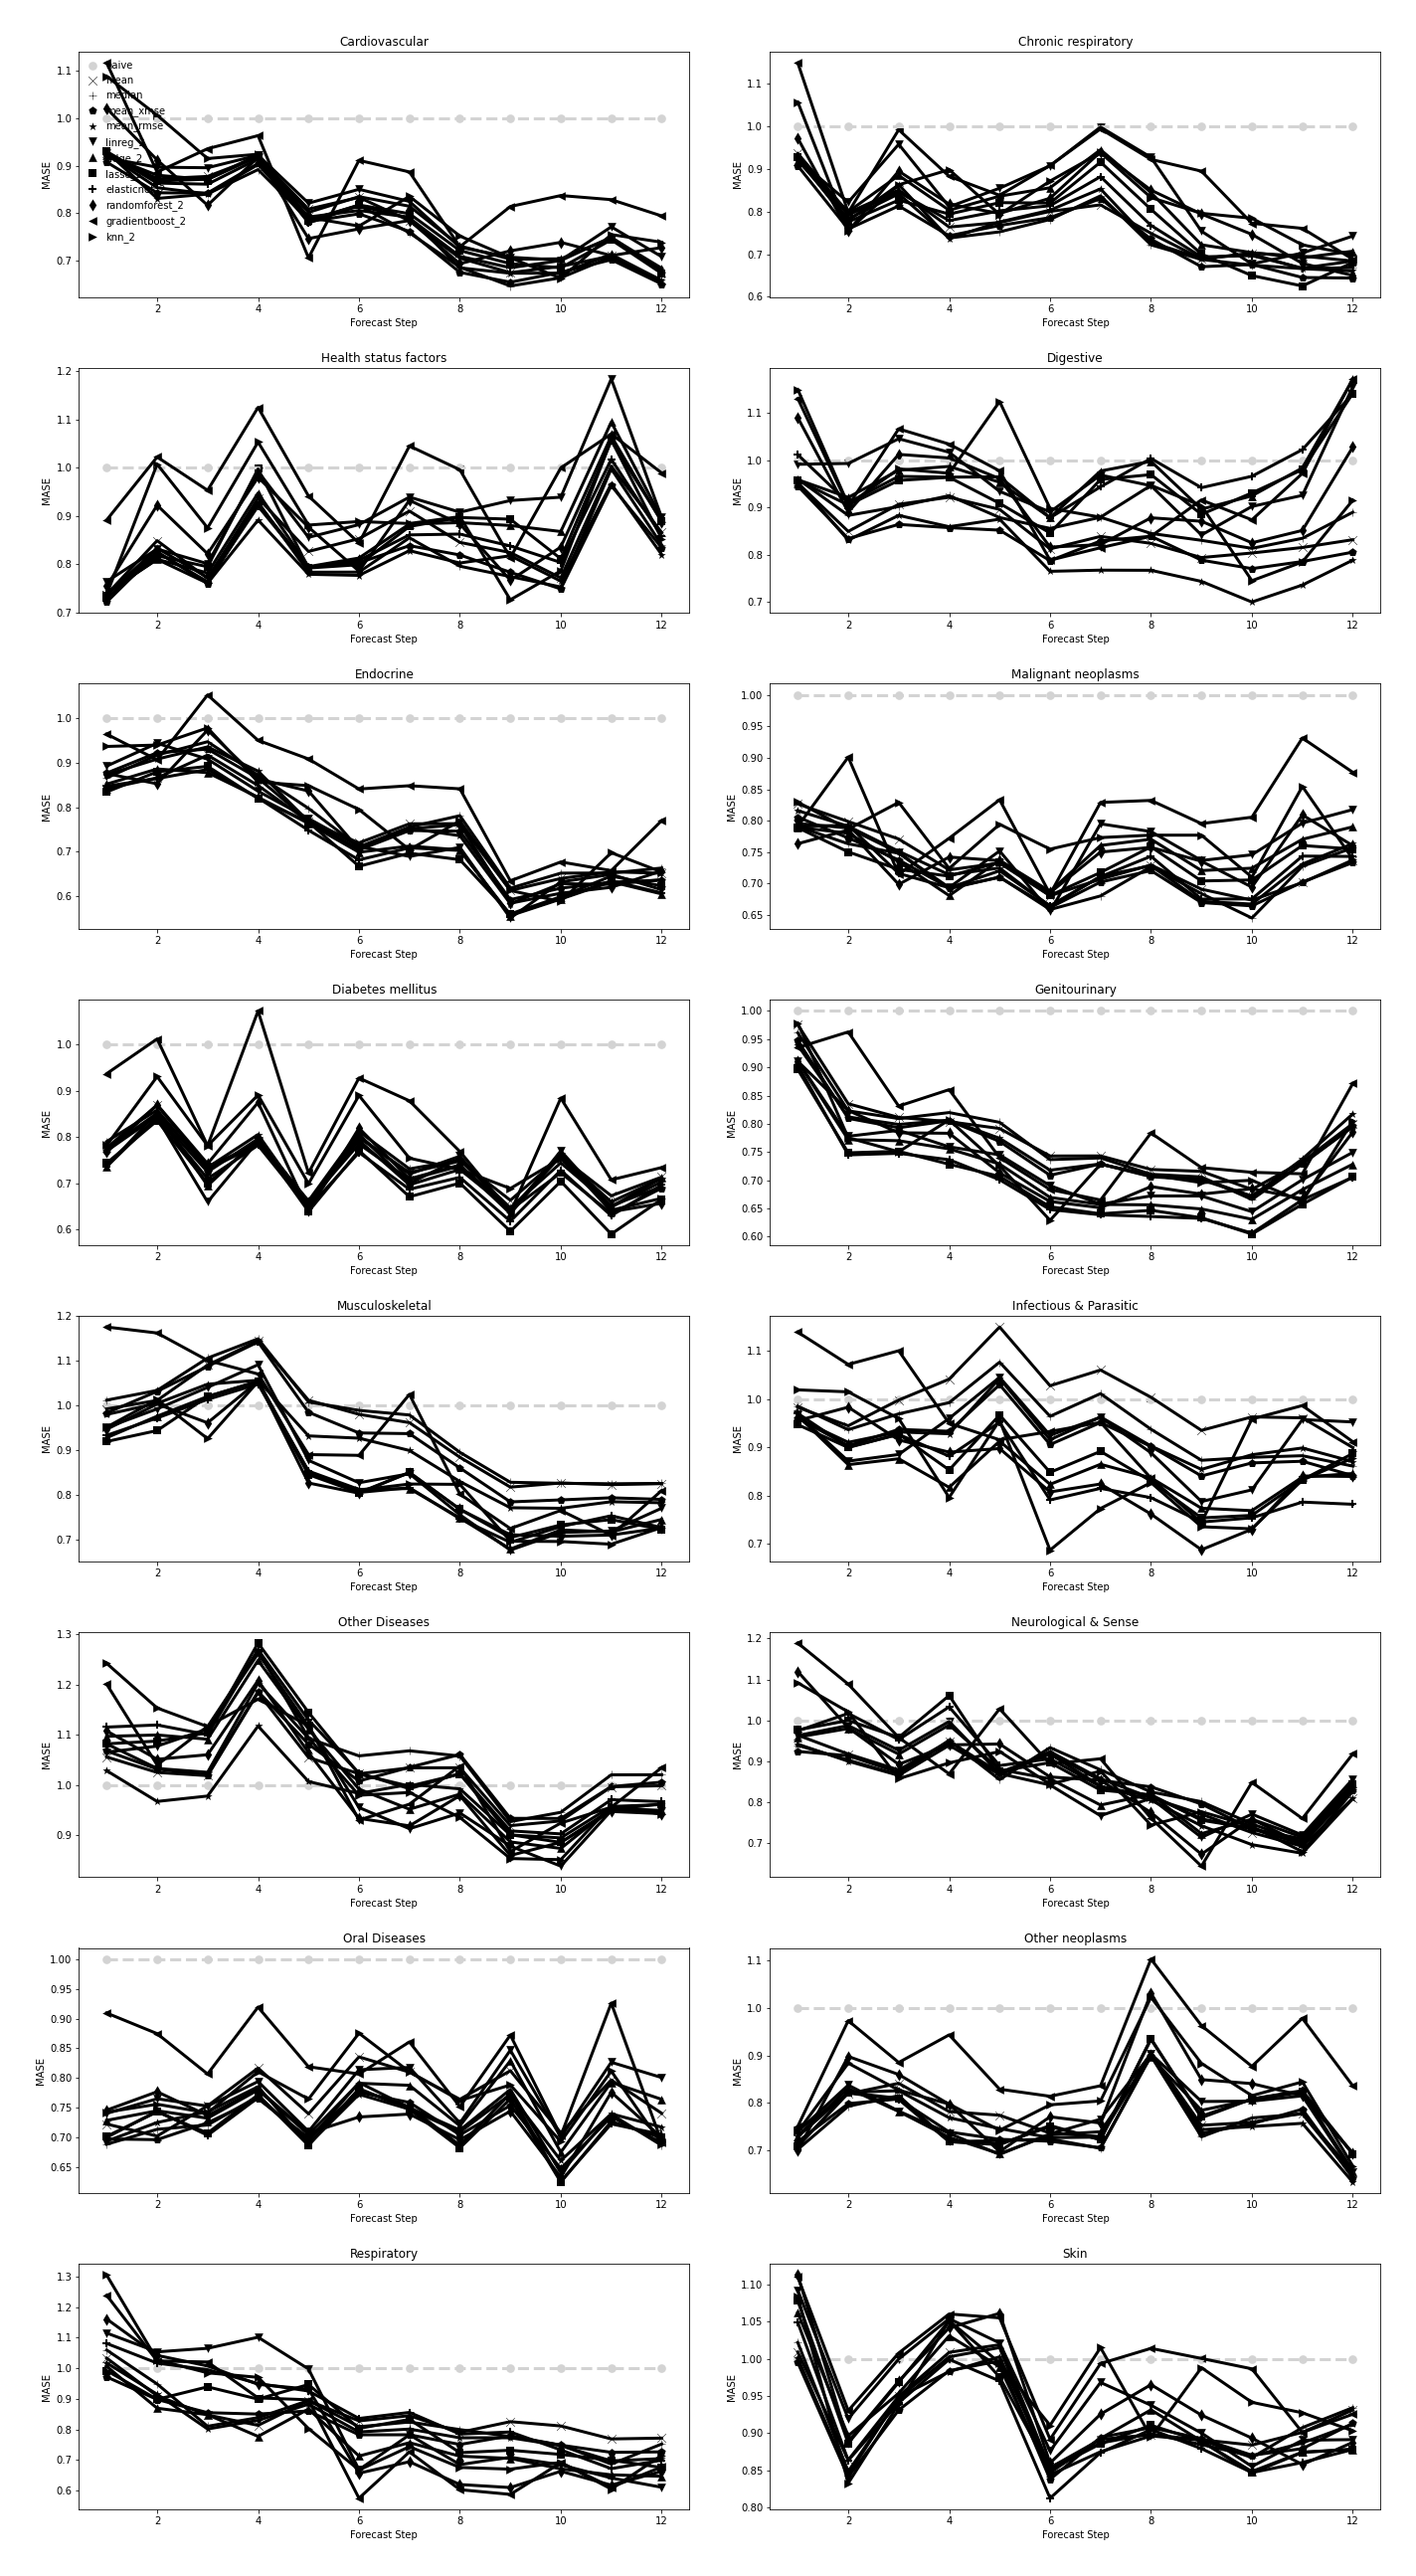

In [306]:
def plot_by_disease(target_variables_file, error_metric_directory, error_metric, output_file):
    disease_list = []
    with open(target_variables_file, 'r') as file:
        for line in file:
            # Remove linebreak which is the last character of the string
            target_variable = line[:-1]
            # Add item to the list
            disease_list.append(target_variable)
    fig, ax = plt.subplots(8,2, figsize=(20, 36))
    fig.tight_layout(pad=5.0)
    count = 0
    countx = 0
    county = 0
    for disease in disease_list: 
        error_df = create_error_df(disease, error_metric_directory, error_metric)
        error_df = error_df

        for model in error_df.columns.values[np.r_[0, 8:19]]:
        #for model in error_df.columns.values[np.r_[:8]]:
            color = color_picker(model)
            marker = marker_picker(model)
            if model == 'naive':
                ax[countx, county].plot(error_df.index.values, error_df[model], linestyle='--', linewidth=3, color='lightgrey')
                ax[countx, county].scatter(error_df.index.values, error_df[model], label=model, marker=marker, s=75, color='lightgrey')
            else:
                ax[countx, county].plot(error_df.index.values, error_df[model], linestyle='-', linewidth=3, color=color)
                ax[countx, county].scatter(error_df.index.values, error_df[model], label=model, marker=marker, s=75, color=color)
        ax[countx, county].set_title(F'{rename_disease(disease)}')
        ax[countx, county].set(xlabel='Forecast Step', ylabel=error_metric)
        if count == 0:
            ax[countx, county].legend(loc='upper left')
        
        if count%2 == 0:
            county += 1
        if count%2 == 1:
            countx += 1
            county -= 1
        count += 1    
    plt.savefig(output_file) 
        

#plot_by_disease('selected_variables.txt', 'error_metrics', 'MAPE', 'Fig2_MAPE_by_Disease.pdf')
plot_by_disease('selected_variables.txt', 'error_metrics_full', 'MASE', 'Fig3B_MASE_by_Disease.tiff')

In [303]:
def create_heatmap_df(error_df):
    return error_df.transpose()

In [27]:
def heatmap_plot(ax, heatmap_df, disease, first):
    img = ax.imshow(heatmap_df, cmap='Reds')
    ax.set_aspect(aspect=1)
    

    if first:
        x_label_list = heatmap_df.columns.values
        y_label_list = heatmap_df.index.values
        

    if not first:
        x_label_list = []
        y_label_list = heatmap_df.index.values

    ax.set_xticks(np.arange(len(x_label_list)))
    ax.set_yticks(np.arange(len(y_label_list)))
        
    ax.set_xticklabels(x_label_list)
    ax.set_yticklabels(y_label_list)

    replace_dict = {'Factors influencing health status and contact with health services': 'Health status factors',
                    'Cardiovascular disease':'Cardiovascular',
                    'Digestive disease':'Digestive',
                    'Endocrine disorders':'Endocrine',
                    'Genitourinary disorders':'Genitourinary',
                    'Infectious and Parasitic Diseases':'Infectious & Parasitic',
                    'Musculoskeletal disease':'Musculoskeletal',
                    'Neurological and sense disorders':'Neurological & Sense',
                    'Oral Diseases':'Oral',
                    'Respiratory Infection':'Respiratory',
                    'Skin diseases':'Skin',
                    'Ill-defined injuries/accidents':'Other Injuries',
                    'Ill-defined diseases':'Other Diseases'
                   }

    if disease in replace_dict.keys():
        disease = replace_dict[disease]
        
    ax.set_ylabel(disease, rotation='vertical', fontsize=fontsize, labelpad=30)
    
    ax.xaxis.tick_top()
        

    ax.add_patch(Rectangle((-0.5, -0.5), 12, 12, fill=False, edgecolor='black', lw=15))
    ax.add_patch(Rectangle((-0.5, 7.5), 12, 4, fill=False, edgecolor='gray', lw=15))
    #fig.colorbar(img, ticks=[heatmap_df.min().min(), heatmap_df.max().max()], orientation='horizontal')

In [28]:
def plot_disease_heatmap(target_variables_file, error_metric_directory, error_metric):
    disease_list = []
    with open(target_variables_file, 'r') as file:
        for line in file:
            # Remove linebreak which is the last character of the string
            target_variable = line[:-1]
            # Add item to the list
            disease_list.append(target_variable)
    '''
    disease_list.remove('Nutritional deficiencies')
    disease_list.remove('Congenital Abnormalities')
    disease_list.remove('Perinatal conditions')

    # Removed because error value not ideal (MAPE > 20%)
    disease_list.remove('Maternal conditions')
    disease_list.remove('Other neoplasms')
    disease_list.remove('Mental disorders')
    '''
    print(disease_list)
    fig, ax = plt.subplots(nrows=8, ncols=2, figsize=(20,60))
    for disease in disease_list:
        d_index = disease_list.index(disease)
        if d_index < 8:
            if d_index == 0:
                heatmap_df = create_heatmap_df(create_error_df(disease, error_metric_directory, error_metric))
                heatmap_plot(ax[d_index][0], heatmap_df, disease, True)
            else:
                heatmap_df = create_heatmap_df(create_error_df(disease, error_metric_directory, error_metric))
                heatmap_plot(ax[d_index][0], heatmap_df, disease, False)
        else:
            heatmap_df = create_heatmap_df(create_error_df(disease, error_metric_directory, error_metric))
            heatmap_plot(ax[d_index-10][1], heatmap_df, disease, False)
    plt.subplots_adjust(hspace=0, wspace=0)
    plt.savefig('disease_heatmap.pdf') 

In [205]:
#plot_disease_heatmap('selected_variables.txt', 'error_metrics', 'MAPE')

In [30]:
def create_pvalue_df(target_var, pvalue_directory, step):
    directory = os.path.join(target_var, pvalue_directory)

    pvalue_path = os.path.join(directory, F'L8_S{step}.csv')

    if os.path.isfile(pvalue_path):
        pvalue_df = pd.read_csv(pvalue_path, index_col=0)
    return pvalue_df

In [112]:
# -1 is red non-equivalence, one model is better than other
# 1 is black equivalence, cannot conclude one model is better
# 66 cells in each matrix, across 12 steps
# for comparing combi with simple, 8 simple x 4 combi = 32 per matrix
# 16 diseases
def create_dm_table(target_variables_file, pvalue_directory):
    disease_list = []
    with open(target_variables_file, 'r') as file:
        for line in file:
            # Remove linebreak which is the last character of the string
            target_variable = line[:-1]
            # Add item to the list
            disease_list.append(target_variable)
    dm_table_df = pd.DataFrame()
    for disease in disease_list:
        for step in range(1,13):
            df = create_pvalue_df(disease, 'pvalue', step)
            df = df.iloc[0:8,8:12]
            ne_value = df.isin([-1]).sum(axis=0).sum()
            dm_table_df.at[disease, step] = ne_value
    return dm_table_df

dm_df = create_dm_table('selected_variables.txt', 'pvalue')
#round(dm_df.sum(axis=0)/(32*16)*100, 3)
round(dm_df/32*100, 3)

,1,2,3,4,5,6,7,8,9,10,11,12
Cardiovascular disease,46.875,43.750,50.000,46.875,56.250,53.125,46.875,46.875,40.625,37.500,43.750,43.750
Chronic respiratory disease,59.375,43.750,43.750,53.125,59.375,65.625,65.625,53.125,62.500,62.500,65.625,75.000
Factors influencing health status and contact with health services,50.000,62.500,50.000,53.125,56.250,50.000,53.125,46.875,46.875,53.125,53.125,59.375
Digestive disease,68.750,65.625,65.625,78.125,75.000,75.000,78.125,81.250,75.000,81.250,87.500,87.500
Endocrine disorders,56.250,53.125,59.375,71.875,75.000,75.000,75.000,68.750,62.500,62.500,65.625,59.375
Malignant neoplasms,56.250,62.500,65.625,75.000,65.625,50.000,56.250,53.125,71.875,65.625,62.500,75.000
Diabetes mellitus,87.500,81.250,78.125,81.250,81.250,75.000,75.000,75.000,75.000,75.000,78.125,78.125
Genitourinary disorders,43.750,40.625,50.000,40.625,43.750,37.500,37.500,43.750,46.875,40.625,37.500,37.500
Musculoskeletal disease,59.375,43.750,43.750,46.875,62.500,62.500,56.250,62.500,56.250,59.375,46.875,56.250
Infectious and Parasitic Diseases,62.500,62.500,53.125,43.750,50.000,65.625,62.500,62.500,71.875,75.000,78.125,75.000


In [31]:
def dm_heatmap_plot(ax, pvalue_df, disease, step, xfirst, yfirst):

    ## Set Colors
    colours = ['#FB0006', '#D5D5D5', '#000000']
    bins = [-1 , 0 , 1]
    assert len(bins)== len(colours)
    cmap = mpl.colors.ListedColormap(colours)
    norm = mpl.colors.BoundaryNorm(boundaries=bins, ncolors=len(cmap.colors)-1 )
    
    
    img = ax.imshow(pvalue_df, cmap=cmap, norm=norm)
    ax.set_aspect(aspect=1)
    

    if xfirst and yfirst:
        x_label_list = pvalue_df.columns.values
        x_label = F'Step {step}'
        y_label_list = pvalue_df.index.values
        y_label = disease

    if not xfirst and yfirst:
        x_label_list = pvalue_df.columns.values
        x_label = F'Step {step}'
        y_label_list = []
        y_label = ''
        
    if xfirst and not yfirst:
        x_label_list = []
        x_label = ''
        y_label_list = pvalue_df.index.values
        y_label = disease

    if not xfirst and not yfirst:
        x_label_list = []
        x_label = ''
        y_label_list = []
        y_label = ''

    ax.set_xticks(np.arange(len(x_label_list)))
    ax.set_yticks(np.arange(len(y_label_list)))

    # Minor ticks
    ### THIS IS HARDCODED 12
    ax.set_xticks(np.arange(-.5, 12, 1), minor=True)
    ax.set_yticks(np.arange(-.5, 12, 1), minor=True)

    # Gridlines based on minor ticks
    ax.grid(which='minor', color='#C7C7C7', linestyle='-', linewidth=1)

    # Remove minor ticks
    ax.tick_params(which='minor', bottom=False, left=False)
        
    ax.set_xticklabels(x_label_list, rotation = 45, ha = 'left')
    ax.set_yticklabels(y_label_list)

    replace_dict = {'Factors influencing health status and contact with health services': 'Health status factors',
                    'Cardiovascular disease':'Cardiovascular',
                    'Digestive disease':'Digestive',
                    'Endocrine disorders':'Endocrine',
                    'Genitourinary disorders':'Genitourinary',
                    'Infectious and Parasitic Diseases':'Infectious & Parasitic',
                    'Musculoskeletal disease':'Musculoskeletal',
                    'Neurological and sense disorders':'Neurological & Sense',
                    'Oral Diseases':'Oral',
                    'Respiratory Infection':'Respiratory',
                    'Skin diseases':'Skin',
                    'Ill-defined injuries/accidents':'Other Injuries',
                    'Ill-defined diseases':'Other Diseases'
                   }

    if y_label in replace_dict.keys():
        y_label = replace_dict[y_label]

    ax.set_xlabel(x_label, rotation='horizontal', fontsize=fontsize, labelpad=20)
    ax.set_ylabel(y_label, rotation='vertical', fontsize=fontsize, labelpad=20)
    
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top') 

    #ax.add_patch(Rectangle((-0.5, -0.5), 12, 12, fill=False, edgecolor='black', lw=3))
    #ax.add_patch(Rectangle((-0.5, 7.5), 8, 4, fill=False, edgecolor='red', lw=3))
    #fig.colorbar(img, ticks=[heatmap_df.min().min(), heatmap_df.max().max()], orientation='horizontal')

In [187]:
def plot_disease_dm_heatmap(target_variables_file, pvalue_directory, nstep):
    disease_list = []
    with open(target_variables_file, 'r') as file:
        for line in file:
            # Remove linebreak which is the last character of the string
            target_variable = line[:-1]
            # Add item to the list
            disease_list.append(target_variable)
    
    print(disease_list)
    fig, ax = plt.subplots(nrows=len(disease_list), ncols=nstep, figsize=(39,53))
    

    for step in range(1, 2):
        for disease in disease_list:
            if disease_list.index(disease) == 0:
                pvalue_df = create_pvalue_df(disease, pvalue_directory, step)
                dm_heatmap_plot(ax[disease_list.index(disease)][step-1], pvalue_df, disease, step, True, True)
            else:
                pvalue_df = create_pvalue_df(disease, pvalue_directory, step)
                dm_heatmap_plot(ax[disease_list.index(disease)][step-1], pvalue_df, disease, step, True, False)
    
    for step in range(2, nstep+1):
        for disease in disease_list:
            if disease_list.index(disease) == 0:
                pvalue_df = create_pvalue_df(disease, pvalue_directory, step)
                dm_heatmap_plot(ax[disease_list.index(disease)][step-1], pvalue_df, disease, step, False, True)
            else:
                pvalue_df = create_pvalue_df(disease, pvalue_directory, step)
                dm_heatmap_plot(ax[disease_list.index(disease)][step-1], pvalue_df, disease, step, False, False)
    
    
    plt.subplots_adjust(hspace=0, wspace=0)
    plt.savefig('Fig6_DM_Heatmap.pdf') 

['Cardiovascular disease', 'Chronic respiratory disease', 'Factors influencing health status and contact with health services', 'Digestive disease', 'Endocrine disorders', 'Malignant neoplasms', 'Diabetes mellitus', 'Genitourinary disorders', 'Musculoskeletal disease', 'Infectious and Parasitic Diseases', 'Ill-defined diseases', 'Neurological and sense disorders', 'Oral Diseases', 'Other neoplasms', 'Respiratory Infection', 'Skin diseases']


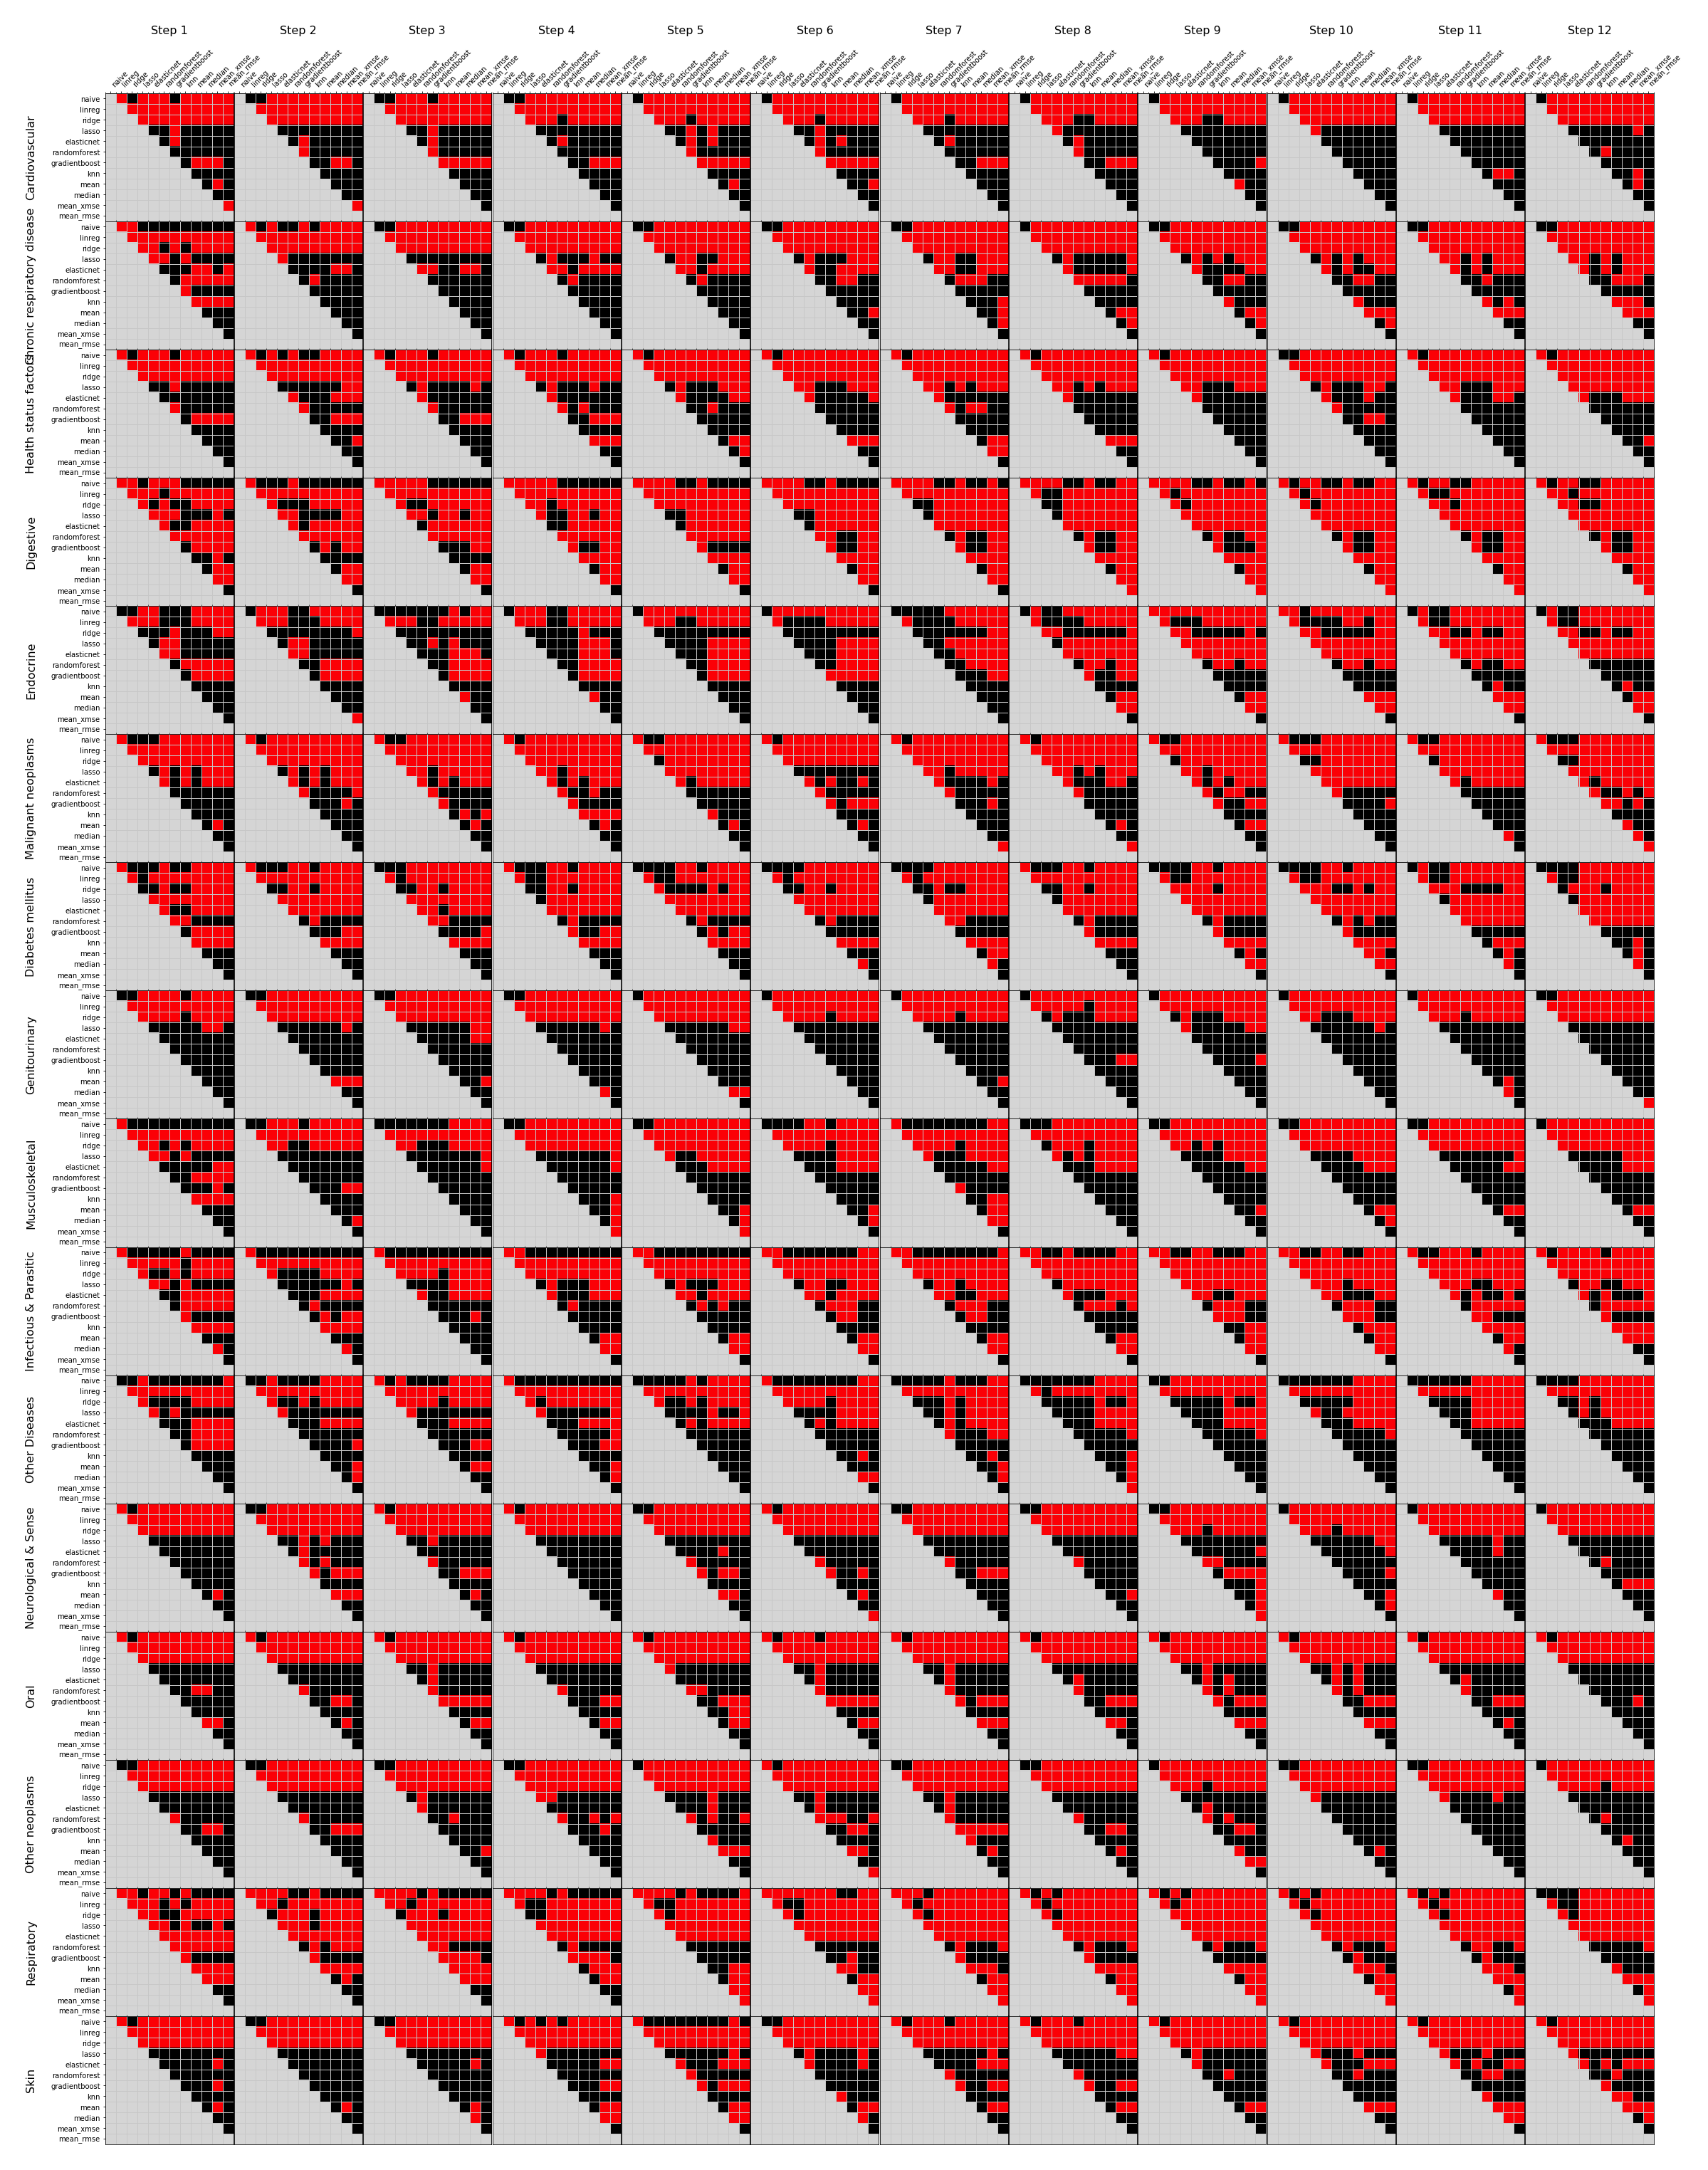

In [188]:
## RED is non-equivalence, i.e. one model is better at forecasting than another
## BLACK is equivalence, i.e. no evidence to show either model performs better
plot_disease_dm_heatmap('selected_variables.txt', 'pvalue', 12)